In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug
import datetime
import pickle
import cv2

from keras.models import load_model, save_model
from keras.layers.core import Lambda
from keras.utils import to_categorical
from tensorflow.python.framework import ops
from keras import backend as K

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# the next instructions are used to make results reproducible
SEED = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.set_random_seed(SEED)
aug.seed(SEED)

In [3]:
################################################################################
### MODIFIABLE VARIABLES
################################################################################
ROOT_PATH = '/home/hippolyte/Documents/universite/m1/TER/'
DATASET_NAME = 'chest_xray/'
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']

################################################################################
### DON'T CHANGE THESE VARIABLES
################################################################################
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH   = ROOT_PATH + 'arrays/'   + DATASET_NAME + '/'
MODEL_PATH   = ROOT_PATH + 'models/'   + DATASET_NAME + '/'
# create the directory to save arrays if it doesn't exist
#! mkdir -pv ARRAY_PATH, MODEL_PATH

# get directories and labels
DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))
# helpers for labels
NUM_LABELS = len(LABELS)
LABEL_MAPPING = {label: code for code, label in enumerate(LABELS)}
# helper for paths
PATHS = {directory: DATASET_PATH + directory + '/' for directory in DIRECTORIES}

In [4]:
print(DIRECTORIES)
print(LABELS)
print(LABEL_MAPPING)

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [5]:
def label_code_to_str(label_code: int) -> str:
    """
    TODO
    """
    for label, code in LABEL_MAPPING.items():
        if label_code == code:
            return label

    raise ValueError('Couldn\'t find the code {} in labels'.format(label_code))

def get_data_dir(directory: str,
                 array_dir: str,
                 height: int=224,
                 width: int=224,
                 channels: int=3):
    """
    TODO
    """
    shape_str = '({},{},{})'.format(height, width, channels)
    filename = array_dir + directory + shape_str + '.h5'
    print('Getting {} images from {}'.format(shape_str, filename))
    
    # some helper variables
    start = datetime.datetime.now()
    
    with h5py.File(filename, 'r') as file:
        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)

        # define arrays holding data and labels
        data = np.zeros((num_images, height, width, channels), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        # format is x0 y0 for the first image and so on
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Data shape : {}\nLabels shape : {}'.format(data.shape, labels.shape))
    
    end = datetime.datetime.now()
    print('Found {} images in {} seconds.'.format(data.shape[0],
                                                 (end-start).seconds))
    
    return data, labels

In [6]:
def get_saved_model(model_path):
    """
    """
    return load_model(model_path)

def get_model_performance(model,
                          test_data,
                          test_labels,
                          batch_size=16):
    """
    TODO
    """
    print('Performances for {} model.'.format(model.name))
    print('\n\n')
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)
    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))
    print('\n\n')

    # predictions and groud truth
    preds = model.predict(test_data, batch_size=16)
    preds = np.argmax(preds, axis=-1)
    ground_truth = np.argmax(test_labels, axis=-1)
    
    # confusion matrix
    cm  = confusion_matrix(ground_truth, preds)
    
    # metrics
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    accuracy = np.diag(cm) / np.sum(cm)

    print('Recall : {}'.format(recall))
    print('Precision : {}'.format(precision))
    print('Accuracy : {}'.format(accuracy))
    print('\n\n')

    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm,
                          figsize=(12, 8),
                          hide_ticks=True,
                          cmap=plt.cm.Blues)
    plt.xticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.yticks(range(NUM_LABELS), LABELS) #, fontsize=16)
    plt.show()
    
    return preds

def plot_model_history(history_path):
    """
    TODO
    """
    print('Loading history from {}'.format(history_path))
    history = pickle.load(open(history_path, 'rb'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #, constrained_layout=True)

    # accuracy
    axes[0].plot(history['acc'])
    axes[0].plot(history['val_acc'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['train', 'val'])

    # loss
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['train', 'val'])
    plt.show()

# Just do it

In [7]:
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

data, labels = dict(), dict()

for directory in DIRECTORIES:
    # get data and labels
    data[directory], labels[directory] = get_data_dir(directory,
                                                      array_dir=ARRAY_PATH,
                                                      height=HEIGHT,
                                                      width=WIDTH,
                                                      channels=CHANNELS)

Getting (224,224,3) images from /home/hippolyte/Documents/universite/m1/TER/arrays/chest_xray//test(224,224,3).h5
Data shape : (624, 224, 224, 3)
Labels shape : (624, 2)
Found 624 images in 2 seconds.
Getting (224,224,3) images from /home/hippolyte/Documents/universite/m1/TER/arrays/chest_xray//train(224,224,3).h5
Data shape : (5216, 224, 224, 3)
Labels shape : (5216, 2)
Found 5216 images in 21 seconds.
Getting (224,224,3) images from /home/hippolyte/Documents/universite/m1/TER/arrays/chest_xray//val(224,224,3).h5
Data shape : (16, 224, 224, 3)
Labels shape : (16, 2)
Found 16 images in 0 seconds.


In [8]:
SAVED_MODEL_PATH = MODEL_PATH + '6_model.hdf5'
SAVED_HISTORY_PATH = MODEL_PATH + '6_history'

model = get_saved_model(SAVED_MODEL_PATH)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
______________________

Performances for sequential_2 model.



624/624 [==============================] - 104s 167ms/step
Loss : 0.28446953103710443
Score : 0.9022435897435898



Recall : [0.7991453  0.96410256]
Precision : [0.93034826 0.88888889]
Accuracy : [0.29967949 0.6025641 ]





<Figure size 432x288 with 0 Axes>

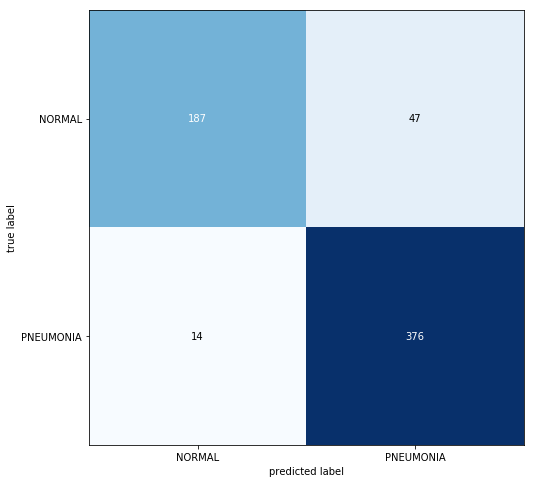

In [9]:
preds = get_model_performance(model,
                              data['test'],
                              labels['test'],
                              batch_size=32)

Loading history from /home/hippolyte/Documents/universite/m1/TER/models/chest_xray//6_history


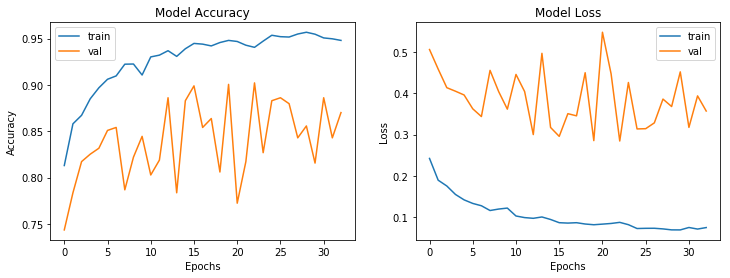

In [10]:
plot_model_history(SAVED_HISTORY_PATH)

# Grad CAM

In [11]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(HEIGHT, WIDTH))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [12]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = get_saved_model(SAVED_MODEL_PATH)
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [13]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], HEIGHT, WIDTH))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [14]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    #top_n = 5
    #top = decode_predictions(predictions, top=top_n)[0]
    #classes = np.argsort(predictions[0])[-top_n:][::-1]
    #print('Model prediction:')
    #for c, p in zip(classes, top):
    #    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
    if cls == -1:
        cls = np.argmax(predictions)
    print('Explanation for {}'.format(label_code_to_str(cls)))
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    #print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [15]:
def compute_saliency_array(model, guided_model, img_array, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    #preprocessed_input = load_image(img_path)
    preprocessed_input = np.expand_dims(img_array, axis=0)
    predictions = model.predict(preprocessed_input)
    #top_n = 5
    #top = decode_predictions(predictions, top=top_n)[0]
    #classes = np.argsort(predictions[0])[-top_n:][::-1]
    #print('Model prediction:')
    #for c, p in zip(classes, top):
    #    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
    if cls == -1:
        cls = np.argmax(predictions)
    print('Explanation for {}'.format(label_code_to_str(cls)))
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    #print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        #cv2.imwrite()
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(141)
        plt.title('Original image')
        plt.axis('off')
        plt.imshow(img_array)
        
        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(img_array) #load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(143)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(144)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

# Let's explore our CNN !

In [16]:
guided_model = build_guided_model()

## One image

Ground truth is PNEUMONIA
Explanation for PNEUMONIA


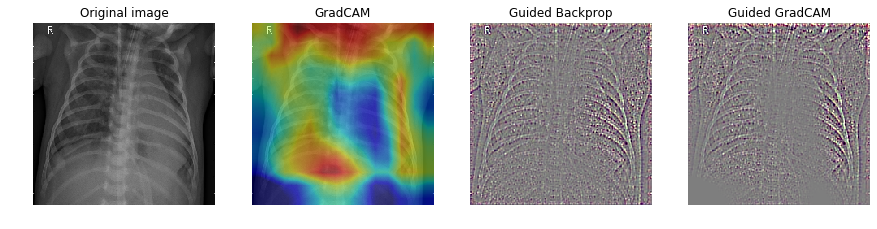

In [17]:
ind = np.random.randint(len(data['test']))
img_test_array = data['test'][ind]

print(f'Ground truth is {label_code_to_str(np.argmax(labels["test"][ind]))}')

gradcam, gb, guided_gradcam = compute_saliency_array(model,
                                               guided_model,
                                               img_test_array,
                                               layer_name='block5_conv4',
                                               cls=-1,
                                               visualize=True,
                                               save=False)

## Multiple images

In [18]:
preds = np.argmax(model.predict(data['val']), 1)
ground_truth = np.argmax(labels['val'], 1)
print('Predicted {} vs Ground Truth {}'.format(preds, ground_truth))

Predicted [0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1] vs Ground Truth [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


Ground truth is NORMAL
Explanation for PNEUMONIA


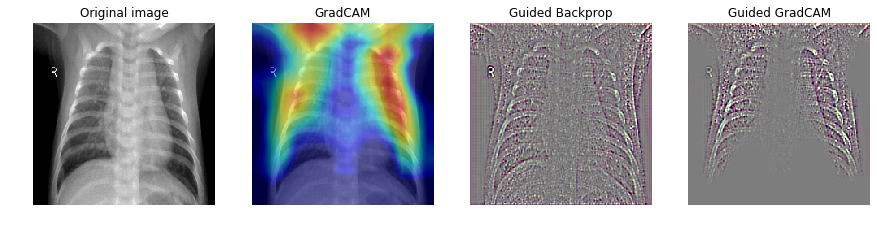

Ground truth is PNEUMONIA
Explanation for PNEUMONIA


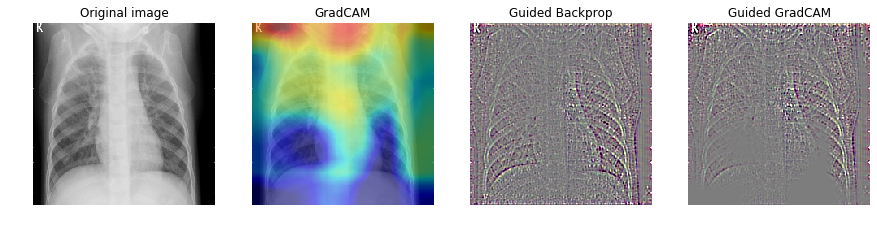

Ground truth is PNEUMONIA
Explanation for PNEUMONIA


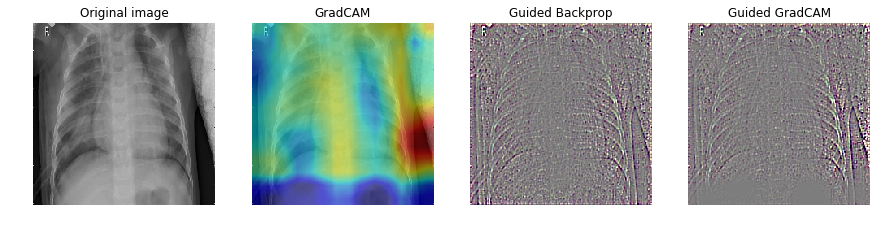

Ground truth is PNEUMONIA
Explanation for PNEUMONIA


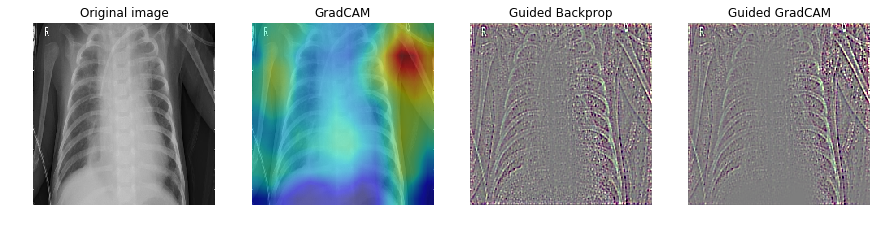

Ground truth is NORMAL
Explanation for PNEUMONIA


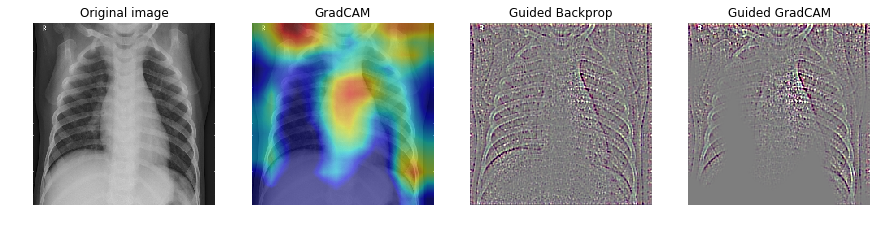

In [21]:
num = 5

for i in range(num):
    ind = np.random.randint(len(data['test']))
    img_test_array = data['test'][ind]

    print(f'Ground truth is {label_code_to_str(np.argmax(labels["test"][ind]))}')

    gradcam, gb, guided_gradcam = compute_saliency_array(model,
                                                   guided_model,
                                                   img_test_array,
                                                   layer_name='block5_conv4',
                                                   cls=-1,
                                                   visualize=True,
                                                   save=False)